# Movie Recommendation System Project
**Data Science Students:**  John Bruemmer, Juliet Day, Xibei(Julian) He 

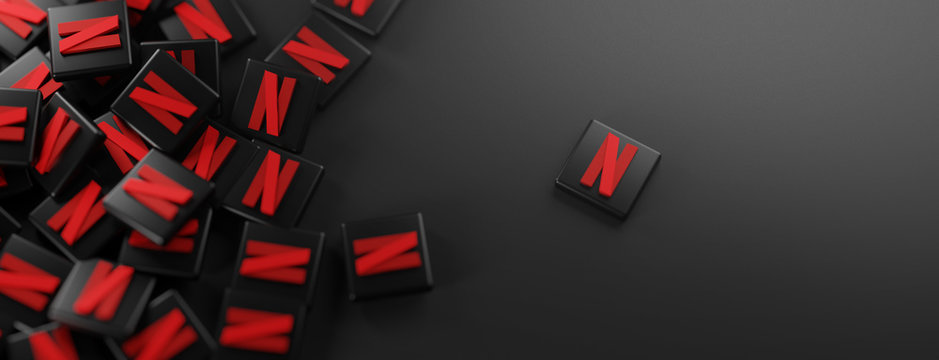

## Overview

The goal to be achieved in this project is to build a quantitative model to generate top 5 movie recommendations for any user. The data we used includes roughly 100,000 ratings across 610 unique users. We utilized a collaborative system so the model would make it's predictions based on user's ratings on other movies. We are presenting our final product to Netflix Recommendation Solution Team, lead by tech supervisor and CTO who oversee the application of algorithms in Netflix's recommendation system.

## Business Problem

Business Understanding: As of 2022, Netflix had a total of 222 million paid members globally. With many accounts having multiple people per household using one account, that would mean many more users.
A study in 2016 found that the average person in the United States spends approximately 23 minutes a day trying to find something to watch. “Breaking that down even further, that works out to be 474 days of unsatisfying, desperate attempts to find anything to satiate the need for new programming before returning to Friends for the hundredth time.”
With a total of 6 billion hours of streaming per month on Netflix and a shocking 474 days of searching for shows to watch per person in their lifetime, it is imperative that customers have custom recommendations based on their favorite previously watched shows and movies. The aim of this project is to create a recommendation system that would customize the user’s recommendations based on their previous ratings.

## Data Understanding

The data we used for this project is from Grouplens. The datasets contains 100,830 ratings on over 9,700 movies, posted by 610 users. There are also 3,600 tags related to these movies. The release year of movies recorded are from 1995 - 2018. We will set "rating" as our target variable in developing recommendation model. 

In [114]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
import surprise
from surprise.prediction_algorithms import *
from surprise import Dataset, Reader, accuracy
from surprise import SVD
from surprise import dataset
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()

# from pandas_profiling import ProfileReport
from collections import defaultdict

# from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

## EDA


Our EDA process includes data cleaning, merging of multiple datasets as well as data visualizing.

In [115]:
link_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [116]:
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [117]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [118]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [119]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


### Data Cleaning

In [120]:
# checking duplicates
movies_df.title.duplicated().sum()

5

In [121]:
movies_df.drop_duplicates(subset='title', inplace=True)
movies_df.title.duplicated().sum()

0

In [122]:
movies_df[['title', 'year']] = movies_df.title.str.split('(', n=1, expand=True)
movies_df['year'] = movies_df.year.str.replace(')', '')
movies_df

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [123]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [124]:
ratings_df.duplicated().sum()

0

In [125]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [126]:
#Convert Tags user and movie ID to string so they can be added together
tags_df['userId'] = tags_df['userId'].apply(str)
tags_df['movieId'] = tags_df['movieId'].apply(str)
#Create a new column so user tags for the same movie can be combined togeter
tags_df['userId_movieId'] = tags_df['userId'] + tags_df['movieId']
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId          3683 non-null   object
 1   movieId         3683 non-null   object
 2   tag             3683 non-null   object
 3   timestamp       3683 non-null   int64 
 4   userId_movieId  3683 non-null   object
dtypes: int64(1), object(4)
memory usage: 144.0+ KB


In [127]:
tags_df['userId_movieId'].duplicated().sum()

1908

In [128]:
#Create a function that combines alll the tags for the same movie and user together
f = {c: ' '.join if c == 'tag' else 'first' for c in ['userId', 'movieId', 'timestamp', 'tag']}

tags_df = tags_df.groupby(
    tags_df.userId_movieId.astype(str), sort=False
).agg(f).reset_index().eval(
    'userId_movieId = @pd.to_numeric(userId_movieId, "coerce").values',
    inplace=False
)

In [129]:
tags_df['userId'] = tags_df['userId'].apply(int)
tags_df['movieId'] = tags_df['movieId'].apply(int)
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId_movieId  1775 non-null   int64 
 1   userId          1775 non-null   int64 
 2   movieId         1775 non-null   int64 
 3   timestamp       1775 non-null   int64 
 4   tag             1775 non-null   object
dtypes: int64(4), object(1)
memory usage: 69.5+ KB


In [130]:
tags_df

,userId_movieId,userId,movieId,timestamp,tag
0,260756,2,60756,1445714994,funny Highly quotable will ferrell
1,289774,2,89774,1445715207,Boxing story MMA Tom Hardy
2,2106782,2,106782,1445715054,drugs Leonardo DiCaprio Martin Scorsese
3,748516,7,48516,1169687325,way too long
4,18431,18,431,1462138765,Al Pacino gangster mafia
...,...,...,...,...,...
1770,6066107,606,6107,1178473747,World War II
1771,6067382,606,7382,1171234019,for katie
1772,6067936,606,7936,1173392334,austere
1773,6103265,610,3265,1493843984,gun fu heroic bloodshed


### Merging Dataframes 
We want to make sure that the number of rows stays the same throughout

In [131]:
ratings_movie_df = ratings_df.merge(movies_df, on  = 'movieId')
ratings_movie_df

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016


In [132]:
ratings_movie_df['userId'].nunique()

610

In [133]:
ratings_movie_df['movieId'].nunique()

9719

In [134]:
ratings_movie_tags_df = ratings_movie_df.merge(tags_df, 
                                               left_on = ['movieId', 'userId'], 
                                               right_on = ['movieId', 'userId'], 
                                               how = 'left')
ratings_movie_tags_df

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN


In [135]:
df_complete = ratings_movie_tags_df.merge(link_df,  how = 'left', on = 'movieId')
df_complete

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
...,...,...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN,118745,30948.0
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN,66806,90351.0
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN,798722,70193.0
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN,1540011,351211.0


In [136]:
#Convert Tags user and movie ID to string so they can be added together
df_complete['userId'] = df_complete['userId'].apply(str)
df_complete['movieId'] = df_complete['movieId'].apply(str)
#Create a new column so user tags for the same movie can be combined togeter
df_complete['userId_movieId'] = df_complete['userId'] + df_complete['movieId']
#Convert user ID and movie ID back to intengers
df_complete['userId'] = df_complete['userId'].apply(int)
df_complete['movieId'] = df_complete['movieId'].apply(int)

### Exploratory Graphs

Here we run some graphs to explore the distribution and unique traits of our datasets

In [137]:
years = []

for year in df_complete['year']:
    year_subset = year
    try: years.append(int(year_subset))
    except: years.append(9999)
        
df_complete['moviePubYear'] = years
print(len(df_complete[df_complete['moviePubYear'] == 9999]))

6798


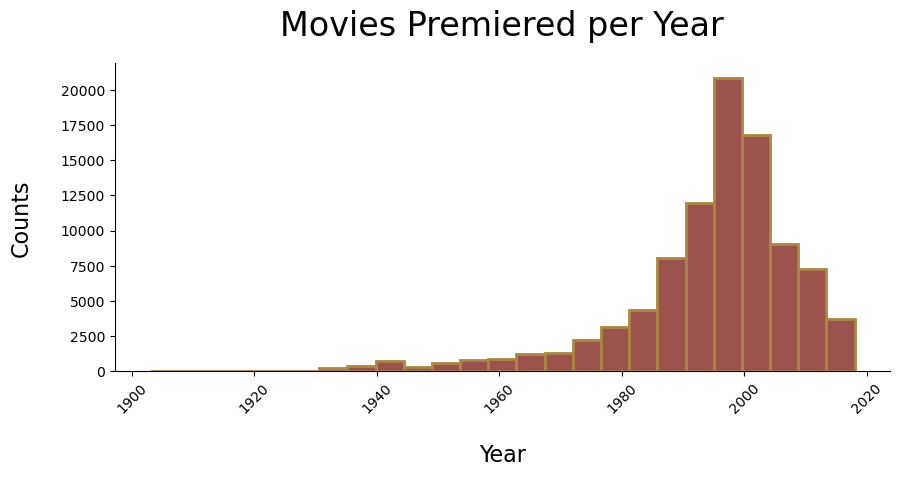

In [138]:
def make_histogram(df, attribute, bins=25, bar_color='#9d534d', edge_color='#ab8742', title='title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        df = df[df['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(df[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(df_complete, 'moviePubYear', title='Movies Premiered per Year', xlab='Year', ylab='Counts')

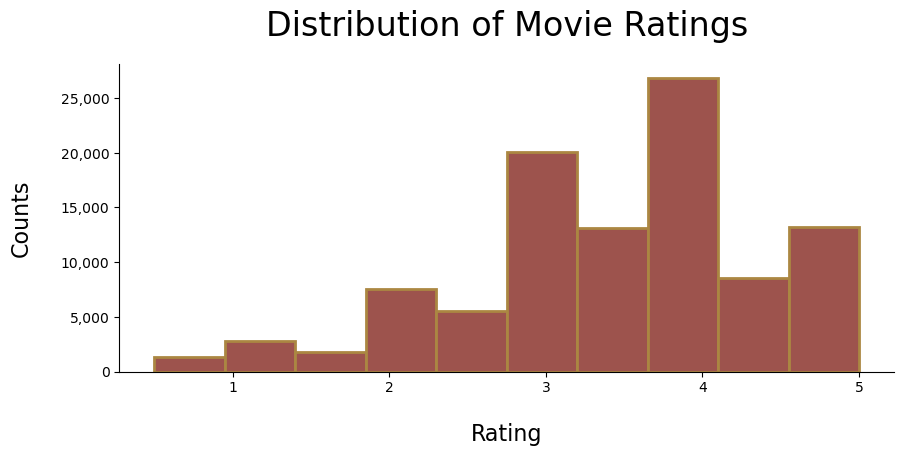

In [139]:
make_histogram(df_complete,'rating', bins = 10, title='Distribution of Movie Ratings', xlab='Rating', ylab='Counts')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Images/movie_ratings', bbox_inches='tight');

In [140]:
# Split Genres to Graph
genre_df = pd.DataFrame(df_complete['genres'].str.split('|').tolist(), index=df_complete['userId_movieId']).stack()
genre_df = genre_df.reset_index([0, 'userId_movieId'])
genre_df.columns = ['userId_movieId', 'Genre']

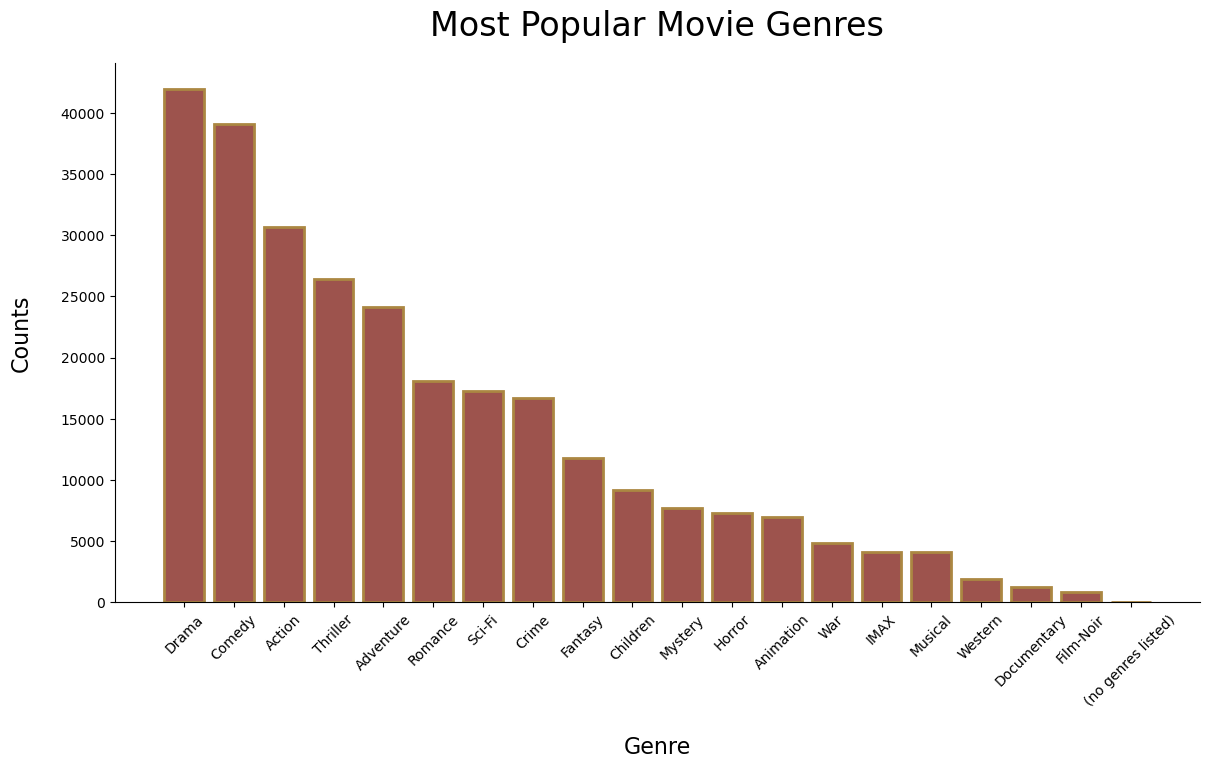

In [142]:
def make_bar_chart(df, attribute, bar_color='#9d534d', edge_color='#ab8742', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = df[attribute].value_counts().index
        ys = df[attribute].value_counts().values
    else:
        xs = df[attribute].value_counts().sort_index().index
        ys = df[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)
    
    
make_bar_chart(genre_df, 'Genre', title='Most Popular Movie Genres', xlab='Genre', ylab='Counts')

In [224]:
#Code to get Average Ratings for each genre

#First add rating for each user and movie
#using the unique userID and MovieID together we add ratings to our genre dataframe
genre_ratings_df = genre_df.merge(df_complete[['userId_movieId', 'rating']],how = 'left' , on = 'userId_movieId')
#Group by genre and find the mean rating for each
genre_means = genre_ratings_df.groupby('Genre').agg('mean')
#Reset the Index for Graphing
genre_means = genre_means.reset_index([0, 'Genre'])
genre_means['Genre'][0] = 'Other genre'
genre_mean_value = genre_means['rating'].mean()
print("The average rating for all genre is: ", genre_mean_value)
# genre_means = genre_means.set_index('Genre')
genre_means_sorted = genre_means.sort_values(by= 'rating', ascending=False)
genre_means_sorted

The average rating for all genre is:  3.5662154107387662


<ipython-input-224-f30b7612d886>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_means['Genre'][0] = 'Other genre'


,Genre,rating
10,Film-Noir,3.918379
18,War,3.805436
7,Documentary,3.797785
6,Crime,3.658946
8,Drama,3.656156
14,Mystery,3.631779
3,Animation,3.630475
12,IMAX,3.619437
19,Western,3.584235
13,Musical,3.565400


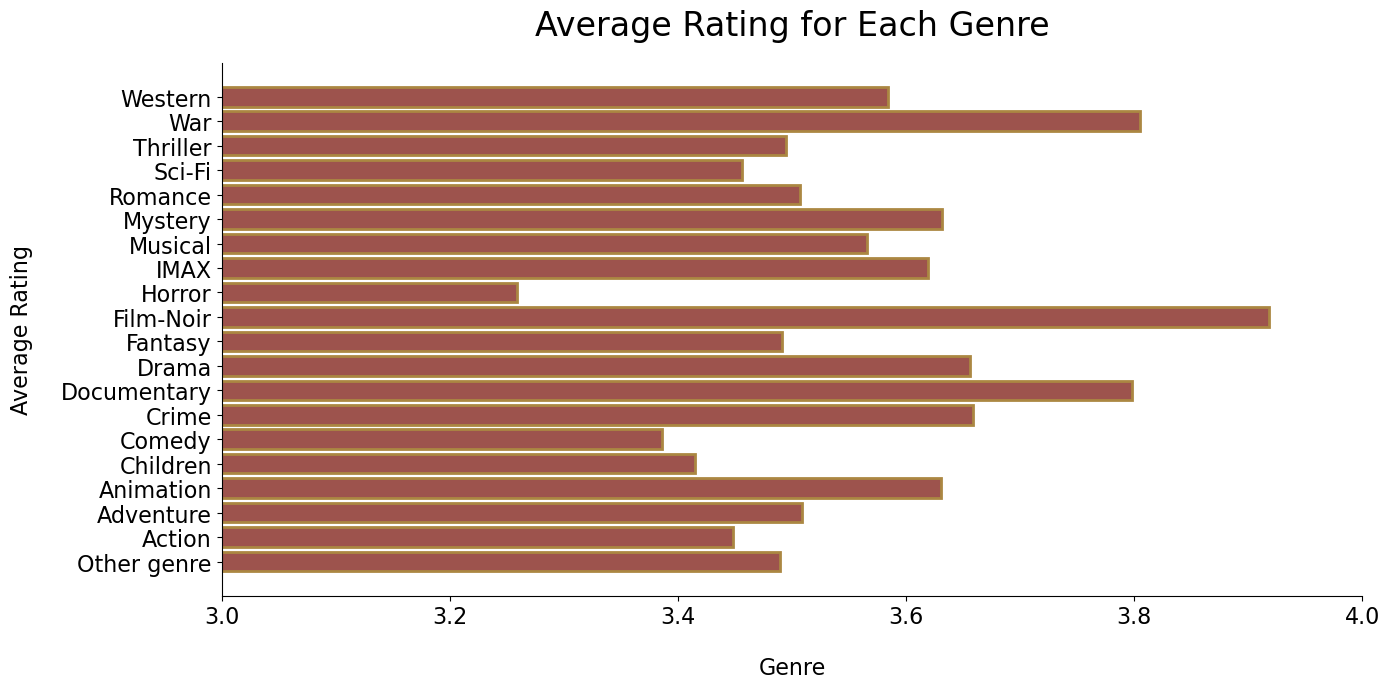

In [219]:
title, xlab, ylab, = 'Average Rating for Each Genre', 'Genre', 'Average Rating'

fig, ax = plt.subplots(figsize=(14, 7))
ax.barh(y = genre_means['Genre'], width = genre_means['rating'], edgecolor='#ab8742', color = '#9d534d', linewidth=2)
plt.xlim([3,4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(title, fontsize=24, pad=20)
ax.set_xlabel(xlab, fontsize=16, labelpad=20)
ax.set_ylabel(ylab, fontsize=16, labelpad=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.savefig('Images/genre_ratings_hbar', bbox_inches='tight');
# creating dataframe
  
# plotting a bar graph

Adding a horizontal line of average rating for all genres to screen out some higher rated genres.

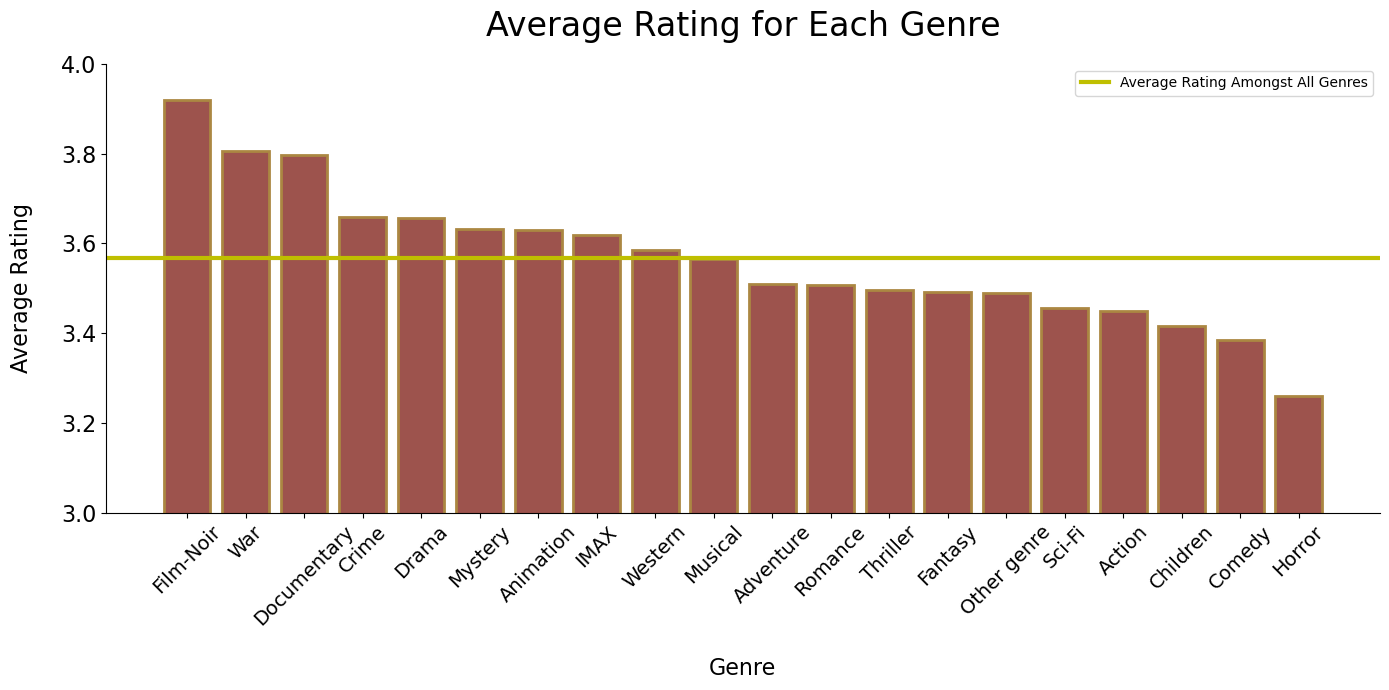

In [226]:
title, xlab, ylab, = 'Average Rating for Each Genre', 'Genre', 'Average Rating'

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x = genre_means_sorted['Genre'], height = genre_means_sorted['rating'], edgecolor='#ab8742', color = '#9d534d', linewidth=2)
plt.axhline(y=genre_mean_value,linewidth=3, color='y')
plt.ylim([3,4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(title, fontsize=24, pad=20)
ax.set_xlabel(xlab, fontsize=16, labelpad=20)
ax.set_ylabel(ylab, fontsize=16, labelpad=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Images/genre_ratings_bar', bbox_inches='tight');
plt.legend(['Average Rating Amongst All Genres'])

# plotting a bar graph

## Data Modeling

The data was analyzed on many fronts. First, we conducted a simple correlation matrix between users and movie ratings to understand how well specific movie ratings are correlated. This provided the basis for our model moving forward. As seen in the Bourne Identity example, the movies that were most correlated were the other movies in the Bourne trilogy. However, there were some movies that we were surprised to find were strongly correlated, such as "The Santa Clause".

In [182]:
df = df_complete
df

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,11,NaN,NaN,114709,862.0,1995,215
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,51,NaN,NaN,114709,862.0,1995,215
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,71,NaN,NaN,114709,862.0,1995,215
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,151,NaN,NaN,114709,862.0,1995,215
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,171,NaN,NaN,114709,862.0,1995,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,610160341,NaN,NaN,118745,30948.0,1997,1
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,610160527,NaN,NaN,66806,90351.0,1971,1
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,610160836,NaN,NaN,798722,70193.0,2005,1
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,610163937,NaN,NaN,1540011,351211.0,2016,1


In [183]:
matrix = df.pivot_table(
    index='userId',
    columns='title',
    values='rating'
)
matrix

title,,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [184]:
def get_similar_movies(movie_title, n_ratings_filter=100, n_recommendations=10):
    similar = matrix.corrwith(matrix[movie_title])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_movie = pd.merge(
        left=corr_similar, 
        right=orig, 
        on='title')[['title', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_movie[corr_with_movie['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    return result.head(n_recommendations)

In [185]:
get_similar_movies('Pulp Fiction ')

C:\Users\Trader\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Trader\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,title,correlation,numRatings
3571,Pulp Fiction,1.000000,307
1540,Fight Club,0.543465,218
2444,Kill Bill: Vol. 1,0.504147,131
4602,Trainspotting,0.437714,102
2445,Kill Bill: Vol. 2,0.421685,110
4717,"Usual Suspects, The",0.411700,204
194,Amelie,0.402193,120
1423,Eternal Sunshine of the Spotless Mind,0.401534,131
3684,Reservoir Dogs,0.394687,131
4653,Twelve Monkeys,0.391141,177


### Train Test Split

In [186]:
data = df[['userId', 'movieId', 'rating']]
data

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
...,...,...,...
100825,610,160341,2.5
100826,610,160527,4.5
100827,610,160836,3.0
100828,610,163937,3.5


### Convert Pandas Dataframe to Surprise Data format

In [187]:
# Create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(0.5, 5))

# Create, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userId'], df['movieId'], df['rating'])]
        self.reader=reader

data = MyDataset(df, reader)

We tried to find algorithms for further grid search for model tuning. 

In [188]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBaseline(), KNNBasic(), BaselineOnly()]:
 # Perform cross validation
 results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
 # Get results & append algorithm name
 tmp = pd.DataFrame.from_dict(results).mean(axis=0)
 tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
 benchmark.append(tmp)
benchmark

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[test_rmse                                             0.880599
 fit_time                                               3.64365
 test_time                                             0.248321
 Algorithm    <surprise.prediction_algorithms.matrix_factori...
 dtype: object,
 test_rmse                                             0.936133
 fit_time                                               4.75101
 test_time                                             0.269389
 Algorithm    <surprise.prediction_algorithms.matrix_factori...
 dtype: object,
 test_rmse                                            0.882557
 fit_time                                               0.2501
 test_time                                             2.63135
 Algorithm    <surprise.prediction_algorithms.knns.KNNBaseline
 dtype: object,
 test_rmse                                         0.958161
 fit_time                                           0.13198
 test_time                                          1.91957
 Algorit

In [189]:
train, test = surprise.model_selection.train_test_split(data, random_state=42)

After seeing the correlation matrix, a baseline model was fit on our training data. A normal predictor was used as the baseline. This assigns a random rating for a movie based off a normal distribution for the movie around the mean. The RMSE for this model was 1.42.

In [190]:
from surprise.prediction_algorithms import NormalPredictor
baseline_model = NormalPredictor()

In [191]:
model_predictions = baseline_model.fit(train).test(test)
baseline_rsme = accuracy.rmse(model_predictions)
baseline_rsme

RMSE: 1.4414


1.4414188007549251

Next, we tried a number of different models with base settings to see which we would like to invest time grid searching hyper-parameters. These models were SVD(Singular Value Decomposition), NMF (Non-Matrix Factorization), KNN Baseline, KNN Basic, and Baseline Only. From these models SVD, NMF, and KNN Basic were chosen for grid searching. A large range was initially used for each parameter and then investigated more closely for each model.

## KNN Basic Algorithm

We are trying different combinations of hyperparameters to find the most optimized parameters.

In [156]:
# param_grid = {'k':[5, 25, 50],'min_k': [1, 5, 10]}
# KNN_model = GridSearchCV(KNNBasic, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# KNN_model.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   55.6s finished


In [157]:
KNN_model.best_params

{'rmse': {'k': 25, 'min_k': 5}}

In [158]:
# param_grid = {'k':[15, 25, 100],'min_k': [1, 5, 10]}
# KNN_model = GridSearchCV(KNNBasic, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# KNN_model.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   59.3s finished


In [159]:
KNN_model.best_params

{'rmse': {'k': 15, 'min_k': 5}}

In [160]:
# param_grid = {'k':[15, 30, 60],'min_k': [1, 5, 10]}
# KNN_model = GridSearchCV(KNNBasic, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# KNN_model.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   59.5s finished


In [161]:
KNN_model.best_params

{'rmse': {'k': 15, 'min_k': 5}}

In [162]:
model = KNNBasic(k=15, min_k=5)
model_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
model_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9312  0.9400  0.9431  0.9383  0.9388  0.9383  0.0039  
Fit time          0.14    0.16    0.17    0.17    0.17    0.16    0.01    
Test time         0.98    1.16    1.02    1.02    1.19    1.07    0.08    


{'test_rmse': array([0.93115069, 0.94000609, 0.94308889, 0.93830467, 0.93875332]),
 'fit_time': (0.13862848281860352,
  0.1619725227355957,
  0.1700444221496582,
  0.16655445098876953,
  0.16699767112731934),
 'test_time': (0.9824628829956055,
  1.1577565670013428,
  1.0156004428863525,
  1.0158700942993164,
  1.190476894378662)}

In [163]:
model_rmse = model_results['test_rmse'].mean()
model_rmse

0.9382607294578389

In [164]:
model.predict(uid=25, iid=52)

Prediction(uid=25, iid=52, r_ui=None, est=3.46757223200064, details={'actual_k': 15, 'was_impossible': False})

## SVD (Matrix Factorization-based Algorithm)

Same tuning process applied in SVD algorithm.

In [165]:
# param_grid = {'n_factors':[10, 15, 25],
#               'n_epochs': [5, 10, 15], 
#               'lr_all': [0.003, 0.005, 0.007],
#               'reg_all': [0.2, 0.4, 0.6]}
# SVD_optimized = GridSearchCV(SVD, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# SVD_optimized.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  7.4min finished


In [166]:
SVD_optimized.best_params

{'rmse': {'n_factors': 15, 'n_epochs': 15, 'lr_all': 0.007, 'reg_all': 0.2}}

In [167]:
# param_grid = {'n_factors':[25, 30, 50],
#               'n_epochs': [15, 20, 30], 
#               'lr_all': [0.007, 0.009, 0.012],
#               'reg_all': [0.2, 0.8, 1.2]}
# SVD_optimized = GridSearchCV(SVD, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# SVD_optimized.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 18.9min finished


In [168]:
SVD_optimized.best_params

{'rmse': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.012, 'reg_all': 0.2}}

In [169]:
model_2 = SVD(n_factors=50, n_epochs=30, lr_all=0.009, reg_all=0.2)
model_2_results = cross_validate(model_2, data, measures=['RMSE'], cv=5, verbose=True)
model_2_results

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8613  0.8716  0.8697  0.8698  0.8725  0.8690  0.0040  
Fit time          3.83    4.30    4.30    4.29    4.30    4.21    0.19    
Test time         0.12    0.30    0.12    0.12    0.12    0.15    0.07    


{'test_rmse': array([0.86129027, 0.87158431, 0.86974401, 0.8698152 , 0.87251165]),
 'fit_time': (3.834454298019409,
  4.298547983169556,
  4.302167177200317,
  4.290050268173218,
  4.302551031112671),
 'test_time': (0.11768579483032227,
  0.30133962631225586,
  0.1178748607635498,
  0.11822247505187988,
  0.11770319938659668)}

In [170]:
model_2_rmse = model_2_results['test_rmse'].mean()
model_2_rmse

0.8689890887016467

## NMF(Collaborative Filtering Algorithm based on Non-negative Matrix Factorization)

The algorithm is pretty similar to SVD, where user and item factors are kept positive. 

In [171]:
# param_grid = {'n_factors':[10, 15, 25, 30, 50],
#               'n_epochs': [5, 15, 25, 50, 100], 
#               }
# NMF_optimized = GridSearchCV(NMF, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# NMF_optimized.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 12.2min finished


In [172]:
NMF_optimized.best_params

{'rmse': {'n_factors': 50, 'n_epochs': 100}}

In [173]:
model_3 = NMF(n_factors=50, n_epochs=100)
model_3_results = cross_validate(model_3, data, measures=['RMSE'], cv=5, verbose=True)
model_3_results


Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9053  0.9014  0.9061  0.9033  0.8999  0.9032  0.0023  
Fit time          19.16   21.64   22.29   21.88   21.92   21.38   1.13    
Test time         0.30    0.11    0.11    0.31    0.10    0.19    0.10    


{'test_rmse': array([0.90534665, 0.90137409, 0.9061166 , 0.90332532, 0.89989328]),
 'fit_time': (19.16456627845764,
  21.64313507080078,
  22.292969942092896,
  21.879640340805054,
  21.924880266189575),
 'test_time': (0.30355191230773926,
  0.10522627830505371,
  0.10671496391296387,
  0.3136289119720459,
  0.10372233390808105)}

In [174]:
model_3_rmse = model_3_results['test_rmse'].mean()
model_3_rmse

0.9032111888812653

SVD was the best performing of these models in terms of Root Mean Square Error and was chosen as our final model. 

### Best Model & Evaluation

Here we have our best performing model and RMSE score for evaluation. 

In [195]:
best_model = SVD(n_factors=50, n_epochs=30, lr_all=0.009, reg_all=0.2, random_state=42)
prediction = best_model.fit(train).test(test)
prediction

[Prediction(uid=212, iid=81834, r_ui=4.0, est=3.7946362204503603, details={'was_impossible': False}),
 Prediction(uid=249, iid=40815, r_ui=3.5, est=3.9050449138076093, details={'was_impossible': False}),
 Prediction(uid=32, iid=1393, r_ui=4.0, est=3.7085963511543634, details={'was_impossible': False}),
 Prediction(uid=33, iid=1653, r_ui=5.0, est=3.9389136727767697, details={'was_impossible': False}),
 Prediction(uid=42, iid=3717, r_ui=4.0, est=3.4487044742463153, details={'was_impossible': False}),
 Prediction(uid=121, iid=539, r_ui=4.0, est=3.347538009221445, details={'was_impossible': False}),
 Prediction(uid=483, iid=88163, r_ui=4.0, est=3.9513906896746787, details={'was_impossible': False}),
 Prediction(uid=474, iid=1243, r_ui=4.0, est=3.7022260492929444, details={'was_impossible': False}),
 Prediction(uid=219, iid=40819, r_ui=2.0, est=3.601804388151531, details={'was_impossible': False}),
 Prediction(uid=76, iid=80463, r_ui=3.0, est=3.329693330519962, details={'was_impossible': Fa

In [196]:
accuracy.rmse(prediction)

RMSE: 0.8772


0.8772444940727718

## How our model works & Recommendations

In [197]:
# user_id is the 100
ratings = df.loc[df['userId'] == 100]
# obtain the required data of this user
ratings = ratings[['userId', 'movieId', 'title', 'year' ]]
ratings

,userId,movieId,title,year
227,100,3,Grumpier Old Men,1995
1277,100,223,Clerks,1994
1510,100,235,Ed Wood,1994
1868,100,296,Pulp Fiction,1994
2482,100,356,Forrest Gump,1994
...,...,...,...,...
87807,100,2262,About Last Night...,1986
87816,100,3244,"Goodbye Girl, The",1977
87828,100,5380,"Importance of Being Earnest, The",2002
87838,100,6183,Pillow Talk,1959


In [198]:
# get the list of the movie ids
unique_ids = df['movieId'].unique()
# get the list of the ids that the userid 100 has watched
iids1001 = df.loc[df['userId']==100, 'movieId']
# remove the rated movies for the recommendations
movies_to_predict = np.setdiff1d(unique_ids,iids1001)

We use our best model to predict and print out recommendations for a random user(UserID = 100).  

In [227]:
#Best model based off of crossvalidation
algo = best_model
algo.fit(train)
my_recs = []
for iid in movies_to_predict:
 my_recs.append((iid, algo.predict(uid='100',iid=iid).est))
pred_df = pd.DataFrame(my_recs, columns=['iid', 'predictions']).sort_values('predictions', ascending=False).head(10)
rec_df = movies_df.merge(pred_df, right_on="iid", left_on="movieId", how = "right")
rec_df[['release_year']] = rec_df['year'].str[-4:]
rec_df = rec_df.drop(["iid", "year"], axis = 1)
rec_df = rec_df[['movieId', 'title', 'genres', 'release_year', 'predictions']]
rec_df.head()

,movieId,title,genres,release_year,predictions
0,1178,Paths of Glory,Drama|War,1957,4.459482
1,177593,"Three Billboards Outside Ebbing, Missouri",Crime|Drama,2017,4.454927
2,3266,Man Bites Dog,Comedy|Crime|Drama|Thriller,1992,4.344420
3,106642,"Day of the Doctor, The",Adventure|Drama|Sci-Fi,2013,4.336889
4,1104,"Streetcar Named Desire, A",Drama,1951,4.316451


This is just checking what ratings that movieID 1178 or Paths of Glory receives.

In [202]:
df[df['movieId'] == 1178]

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
88197,105,1178,4.0,1447574111,Paths of Glory,Drama|War,1957,1051178,NaN,NaN,50825,975.0,1957,12
88198,199,1178,5.0,940380424,Paths of Glory,Drama|War,1957,1991178,NaN,NaN,50825,975.0,1957,12
88199,249,1178,4.0,1346757558,Paths of Glory,Drama|War,1957,2491178,NaN,NaN,50825,975.0,1957,12
88200,305,1178,5.0,1516130775,Paths of Glory,Drama|War,1957,3051178,NaN,NaN,50825,975.0,1957,12
88201,312,1178,5.0,1043177080,Paths of Glory,Drama|War,1957,3121178,NaN,NaN,50825,975.0,1957,12
88202,339,1178,4.5,1460868619,Paths of Glory,Drama|War,1957,3391178,NaN,NaN,50825,975.0,1957,12
88203,391,1178,5.0,1030827723,Paths of Glory,Drama|War,1957,3911178,NaN,NaN,50825,975.0,1957,12
88204,414,1178,4.0,1025108482,Paths of Glory,Drama|War,1957,4141178,NaN,NaN,50825,975.0,1957,12
88205,421,1178,4.5,1311495271,Paths of Glory,Drama|War,1957,4211178,NaN,NaN,50825,975.0,1957,12
88206,469,1178,5.0,965661977,Paths of Glory,Drama|War,1957,4691178,NaN,NaN,50825,975.0,1957,12


## **Conclusions**
Our recommendation system utilized a collaborative-based model to make predictions based on users' previous ratings. Our best model had a RMSE of 0.88, meaning our predictions will be off by 0.88 points on average. This is 38% better than our baseline model, which has a RMSE of 1.43. We believe that our model would improve your customers' experience using Netflix.

## **Next Steps**
1. **Seasonality:** to further enhance our model, we would like to incorporate time series data into our datasets so that we could study and identify seasonal pattern for movie recommendations for our subscribers. 

<br>

2. **Time of day:** the time of day people are searching for new content may influence the recommendations they should receive. For example, what people like to watch at 2pm vs. 9pm vs. 2am may be different, and our recommendation system should account for that. 

<br>

3. **Bingeability:** having an idea of how long a user stays on Netflix once they are engaged will lead to a different recommendations. Therefore, if people stay on the platform for a long time, we can recommend more “mind-numbing” movies whereas if people typically engage with the product for a lesser time we want to recommend something that is higher quality but leaves a lasting impression.